In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from UtilityGraph import *
from Defence import *
from Corruption import *
from UtilityMLP import *
import random
from collections import deque
from scipy.stats import *
import copy
import seaborn as sns
from Test import *
import math
import itertools
import pandas as pd
import plotly.express as px
from ipywidgets import interact, IntSlider

Seed = 2001  # for reproducibility
random.seed(Seed)
np.random.seed(Seed) 
torch.manual_seed(Seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(Seed)
    torch.cuda.manual_seed_all(Seed)

# %matplotlib notebook
%matplotlib widget


In [4]:

Seed = 42  # for reproducibility
random.seed(Seed)
np.random.seed(Seed) 
torch.manual_seed(Seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(Seed)
    torch.cuda.manual_seed_all(Seed)
# Graph
required_probability=0.9999
num_nodes, G,A,pos,r_c=build_random_graph(50,required_probability,fix_num_nodes=True) #  ,r_fix=999 or 0.3

In [ ]:
print("num_nodes:",num_nodes)
pos = nx.spring_layout(G)  # Fixed positions for consistent visualization
percentageCorrupt = 0/num_nodes   #Percentage of corrupt clients


var = 30                  # Standard deviation for Gaussian noise
mean = 1                    # Mean for Gaussian noise
Target = np.random.randint(1, num_nodes) # Target client for copycat attack
scale = 1
typeAttack = 0              # 0: No attack, 1: Gaussian noise, 2: Copycat attack, 3: Gaussian addative noise attack, 4: LIE attack

corrupt = True              #If True, corrupt clients are included
CorruptClients = CorruptGeneration(percentageCorrupt, corrupt, num_nodes) #Selection of Corrupt Clients
CorruptClients = np.array(CorruptClients, dtype=int)

lying_nodes = np.where(CorruptClients == 1)[0]
true_nodes = [i for i in range(num_nodes) if i not in lying_nodes]

test1 = 0
# Data
Data = np.zeros([num_nodes,1])
RealMean = 25
RealVar = 30
for i in range(num_nodes):
    Data[i] = np.random.normal(RealMean, np.sqrt(RealVar))
    test1 += G.degree(i)

print(test1/num_nodes)

Control = Data.copy()

neighbors_dict = {}
for ln in lying_nodes:
    neighbors_dict[ln] = list(G.neighbors(ln))

print("Neighbors of lying nodes:", neighbors_dict)

num_nodes: 50
IteNumber of Corrupt nodesration 0, Corrupt nodes: []
10.44
Neighbors of lying nodes: {}


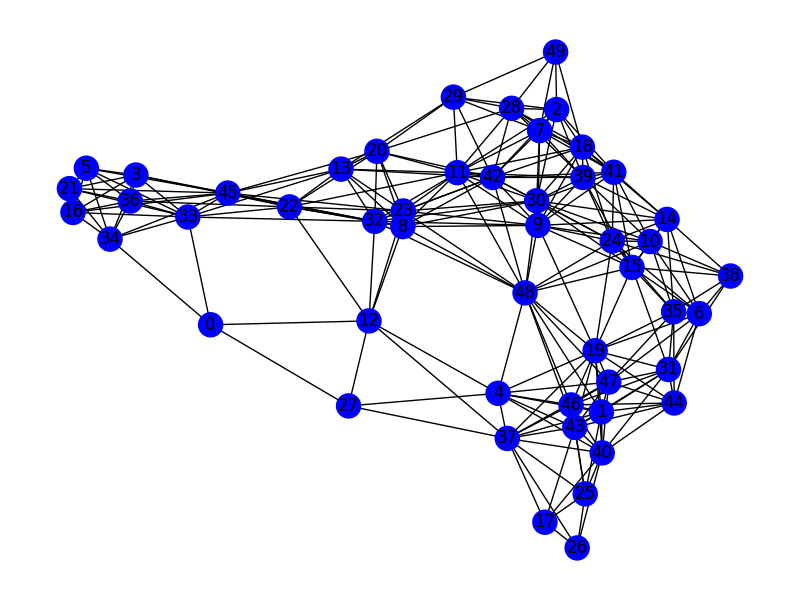

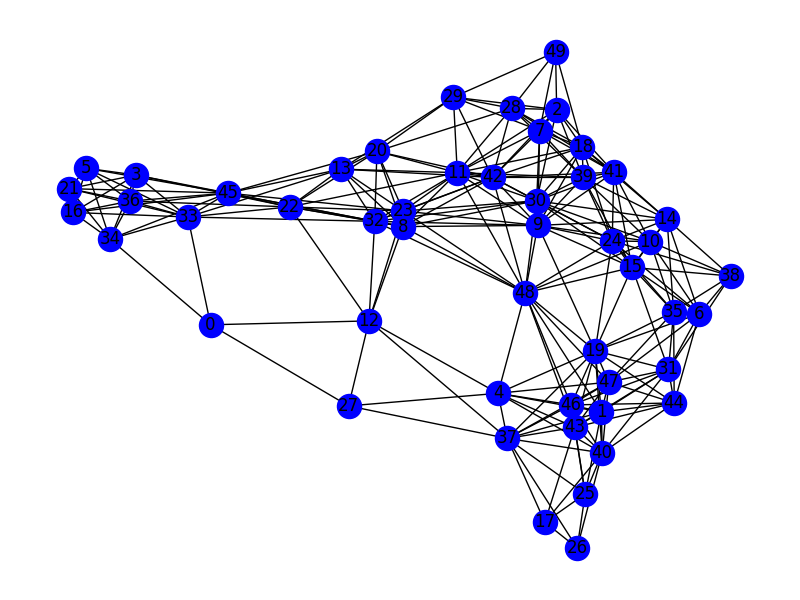

Are the honest‐only nodes still forming a connected subgraph? True


In [6]:
plt.figure(figsize=(8,6))
color_map = []
for node in range(num_nodes):
    if node in lying_nodes:
        color_map.append('red')   # corrupt
    else:
        color_map.append('blue')  # honest

nx.draw(G, pos, with_labels=True, node_color=color_map)
plt.title("Graph with Lying (Red) and Honest (Blue) Nodes")
plt.show()

remaining_nodes = [n for n in G.nodes() if n not in lying_nodes]
G_sub = G.subgraph(remaining_nodes)

pos_sub = {n: pos[n] for n in remaining_nodes}

plt.figure(figsize=(8,6))
nx.draw(G_sub, pos_sub, with_labels=True, node_color="blue")
plt.title("Subgraph After Removing Corrupt Nodes\n(Honest Nodes Only)")

plt.show()

still_connected = nx.is_connected(G_sub)
print("Are the honest‐only nodes still forming a connected subgraph?",
      still_connected)




In [7]:
def iterative_thresholding(values, initial_threshold, tol=1e-3):
    """
    Performs iterative (two-group) thresholding on 'values' array.

    Steps:
    1) Split values into G1 (those > T_old) and G2 (≤ T_old).
    2) m1 = mean(G1), m2 = mean(G2)
    3) T_new = (m1 + m2)/2
    4) Repeat until |T_new - T_old| < tol or we reach max_iter.

    :param values: 1D np.array of floats
    :param initial_threshold: float, starting threshold
    :param tol: float, stopping tolerance
    :param max_iter: int, maximum iteration count
    :return: float, the final threshold
    """
    T_old = initial_threshold

    G1 = values[values > T_old]
    G2 = values[values <= T_old]

    if G1.size == 0 or G2.size == 0:
        T_new = T_old
    else:
        m1 = np.mean(G1)
        m2 = np.mean(G2)
        T_new = 0.5 * (m1 + m2)
    
    # if abs(T_new - T_old) < tol:
    #     break
    T_old = T_new

    return T_old


In [8]:
# def plot_combined_metrics(results):
#     # Group results by noise level
#     noise_groups = {}
#     for res in results:
#         key = res['noise_STD']
#         if key not in noise_groups:
#             noise_groups[key] = []
#         noise_groups[key].append(res)

#     # Create plots
#     fig, axs = plt.subplots(3, 1, figsize=(10, 8))
    
#     # Plot FAR
#     for noise, group in noise_groups.items():
#         far_matrix = np.array([res['FAR'] for res in group])
#         avg_far = np.mean(far_matrix, axis=0)
#         if noise != 0:
#             axs[0].plot(avg_far, label=f'Var = $10^{{{int(np.log10(noise))}}}$')
#     axs[0].set_title('False Alarm Rate')
#     axs[0].set_ylabel('FAR')
#     axs[0].grid(True)
#     plt.legend()

#     # Plot MDR
#     for noise, group in noise_groups.items():
#         mdr_matrix = np.array([res['MDR'] for res in group])
#         avg_mdr = np.mean(mdr_matrix, axis=0)
#         if noise != 0:
#             axs[1].plot(avg_mdr, label=f'Var = $10^{{{int(np.log10(noise))}}}$')
#     axs[1].set_title('Missed Detection Rate')
#     axs[1].set_ylabel('MDR')
#     axs[1].grid(True)
#     plt.legend()

#     # Plot Error
#     for noise, group in noise_groups.items():
#         err_matrix = np.array([res['Error'] for res in group])
#         avg_err = np.mean(err_matrix, axis=0)
#         if noise != 0:
#             axs[2].plot(avg_err, label=f'Var = $10^{{{int(np.log10(noise))}}}$')
#         else:
#            axs[2].plot(avg_err, label=f'Var = 0')
#     axs[2].set_title('Consensus Error')
#     axs[2].set_ylabel('Error')
#     axs[2].set_xlabel('Iteration')
#     axs[2].set_yscale('log')
#     axs[2].grid(True)

#     plt.legend()
#     plt.tight_layout()
#     plt.show()

In [9]:
def plot_combined_metrics(results):
    # Define markers for different sigma values
    markers = ['o', 's', 'd', '^', 'v', '<', '>', 'p', '*', 'h', '+', 'x']
    
    # Group results by noise level
    noise_groups = {}
    for res in results:
        key = res['noise_STD']
        if key not in noise_groups:
            noise_groups[key] = []
        noise_groups[key].append(res)

    # Create plots
    fig, axs = plt.subplots(3, 1, figsize=(10, 8))

    # Convert noise levels to sorted list for consistent markers
    sorted_noises = sorted(noise_groups.keys())

    # Define base sparsity (every N points)
    base_markevery = 40  
    
    # Plot FAR
    for idx, noise in enumerate(sorted_noises):
        group = noise_groups[noise]
        far_matrix = np.array([res['FAR'] for res in group])
        avg_far = np.mean(far_matrix, axis=0)
        marker = markers[idx % len(markers)]  # Cycle through markers
        offset = (idx*50) % base_markevery  # Offset to stagger marker placement
        markevery = (offset, base_markevery)  # Staggered marker appearance
        if noise != 0:
            axs[0].plot(avg_far, marker=marker, markevery=markevery, label=f'$\\sigma^2 = 10^{{{int(np.log10(noise))}}}$', markersize=6)
        else:
            axs[0].plot(avg_far, marker=marker, markevery=markevery, label='$\\sigma^2 = 0$', markersize=6)
    axs[0].set_title('False Alarm Rate')
    axs[0].set_ylabel('FAR')
    axs[0].grid(True)
    
    # Plot MDR
    for idx, noise in enumerate(sorted_noises):
        group = noise_groups[noise]
        mdr_matrix = np.array([res['MDR'] for res in group])
        avg_mdr = np.mean(mdr_matrix, axis=0)
        marker = markers[idx % len(markers)]
        offset = (idx*50) % base_markevery
        markevery = (offset, base_markevery)
        if noise != 0:
            axs[1].plot(avg_mdr, marker=marker, markevery=markevery, label=f'$\\sigma^2 = 10^{{{int(np.log10(noise))}}}$', markersize=6)
        else:
            axs[1].plot(avg_mdr, marker=marker, markevery=markevery, label='$\\sigma^2 = 0$', markersize=6)
    axs[1].set_title('Missed Detection Rate')
    axs[1].set_ylabel('MDR')
    axs[1].grid(True)

    # Plot Error
    for idx, noise in enumerate(sorted_noises):
        group = noise_groups[noise]
        err_matrix = np.array([res['Error'] for res in group])
        avg_err = np.mean(err_matrix, axis=0)
        marker = markers[idx % len(markers)]
        offset = (idx*50) % base_markevery
        markevery = (offset, base_markevery)
        if noise != 0:
            axs[2].plot(avg_err, marker=marker, markevery=markevery, label=f'$\\sigma^2 = 10^{{{int(np.log10(noise))}}}$', markersize=6)
        else:
            axs[2].plot(avg_err, marker=marker, markevery=markevery, label='$\\sigma^2 = 0$', markersize=6)
    axs[2].set_title('Consensus Error')
    axs[2].set_ylabel('Error')
    axs[2].set_xlabel('Iteration')
    axs[2].set_yscale('log')
    axs[2].grid(True)
    axs[2].legend()  # Add legend for the third plot

    plt.tight_layout()
    plt.show()


In [ ]:
def PDMM(
    Data, G, avg_temp, tolerance, c, max_iters, Control,
    averaging, Timer, K_decision, rejection_threshold, perm_threshold, when, corruption_start, lying_nodes, window_size, CorruptValue, Print_Val, noise
):
    """
    PDMM with attacker detection/avoidance, using EXACT eq. (14a), (14b), (13).

    :param Data:                (num_nodes x 1) array of node data
    :param G:                   networkx Graph
    :param avg_temp:            target average for convergence check
    :param tolerance:           stopping threshold for ||x - avg_temp||
    :param c:                   penalty parameter in PDMM
    :param max_iters:           maximum number of iterations
    :param Control:             not used currently
    :param averaging:           alpha in z-update
    :param Timer:               number of iterations = ΔT
    :param K_decision:          longer window for repeated rejections
    :param rejection_threshold: δ_u in eq. (13)
    :param mu:                  1/eta(t) factor for eq. (14b)
    
    :return:
        Error, count, dual_history, x_history, z_history,
        dual_calc_history, x_calc_history
    """

    # Reproducibility seeds
    Seed = 2001
    random.seed(Seed)
    np.random.seed(Seed)
    torch.manual_seed(Seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(Seed)
        torch.cuda.manual_seed_all(Seed)

    num_nodes = G.number_of_nodes()
    x = np.zeros([num_nodes, 1])
    converged = False
    Error = np.array([])

    # Incidence
    A_ij = calc_incidence_nested(G)

    # Get a consistent ordering of the nodes.
    nodes = sorted(G.nodes())
    num_nodes = len(nodes)

    # Create an empty NumPy array for the incidence matrix.
    A = np.zeros((num_nodes, num_nodes))

    # Fill the NumPy array with the entries from the dictionary.
    # If there is no edge from i to j, we leave it as 0.
    for i_idx, i in enumerate(nodes):
        for j_idx, j in enumerate(nodes):
            A[i_idx, j_idx] = A_ij.get(i, {}).get(j, 0)

    D = np.diag(np.sum(A, axis=1))  # Diagonal matrix with node degrees on the diagonal

    # Compute the Laplacian matrix L
    L = D - A
    # Compute the eigenvalues of the Laplacian
    eigenvalues = np.linalg.eigvals(L)
    # Sort eigenvalues
    sorted_eigenvalues = np.sort(eigenvalues)[::-1]

    # Fiedler value is the second smallest eigenvalue
    fiedler_value = sorted_eigenvalues[1]
    # Find the largest eigenvalue
    largest_eigenvalue = np.max(sorted_eigenvalues)

    # print("Largest eigenvalue of the Laplacian:", largest_eigenvalue)
    # print("Fiedler eigenvalue of the Laplacian:", fiedler_value)


    personal_S_history = {}

    # z, y, dual, calc_dual, ...
    # z = np.zeros((num_nodes, num_nodes))
    z = np.random.normal(loc=0, scale=noise, size=(num_nodes, num_nodes))
    z = z * (A != 0) 
    y = np.zeros((num_nodes, num_nodes))
    y_transmit = np.zeros((num_nodes, num_nodes))
    dual = np.zeros((num_nodes, num_nodes))
    calc_dual = np.zeros((num_nodes, num_nodes))
    calc_x = np.zeros((num_nodes, 1))
    temp_y = np.zeros((num_nodes, num_nodes))
    
    mask = np.zeros((num_nodes, num_nodes), dtype=int)
    reject_count = np.zeros((num_nodes, num_nodes), dtype=int)

    dual_history = []
    y_history = []
    x_history = []
    z_history = []
    dual_calc_history = []
    x_calc_history = []
    thresholding = []
    mask_history = []
    MAD = np.zeros((num_nodes, 1))

    dual_calc_history.append(calc_dual.copy())
    median = np.zeros(num_nodes, dtype=float)
    sum_check = np.zeros((num_nodes, num_nodes), dtype=float)
    Thresh_Error = []

    rejected_nodes = set()  # Keeps track of nodes deemed "rejected"
    k = 0
    thresholds = np.zeros(num_nodes, dtype=float)  # each node i has thresholds[i]
    count_reject = 0
    Delta_history = []
    count = 0
    Track = 0
    Average_Threshold = np.zeros(num_nodes, dtype=float)

    while (not converged) and (count < max_iters):
        if count == corruption_start:
            for node in lying_nodes:
                Data[node] = CorruptValue

        # random_node_i = random.randint(0, num_nodes - 1)

        # print("            The count for this iteration is           ", count)

        # --------------------
        # 1) Update x
        # --------------------
        x_new = np.zeros_like(x)
        for i in range(num_nodes):
            corrupt_neighbors = 0
            # corrupt_neighbors = sum(1 for j in G.neighbors(i) if j in rejected_nodes)  # Count rejected neighbors
            numerator_i = Data[i].copy()
            for j in G.neighbors(i):
                if mask[i][j] != -1:
                    numerator_i += -A_ij[i][j] * z[i][j]
                else:
                    corrupt_neighbors += 1
                        # Adjust denominator: exclude rejected nodes from degree count
            effective_degree = G.degree(i) - corrupt_neighbors
            x_new[i] = numerator_i / (1 + c * effective_degree)
        x = x_new
        x_history.append(x.copy())

        # --------------------
        # 2) Update dual
        # --------------------
        for i in range(num_nodes):
            for j in G.neighbors(i):
                # if mask[i][j]!= -1:
                dual[i][j] = z[i][j] + c * (x[i] * A_ij[i][j])
        dual_history.append(dual.copy())

        # --------------------
        # 3) Update y
        # --------------------
        for i in range(num_nodes):
            for j in G.neighbors(i):
                temp_y[i][j] = y[i][j]
                y[i][j] = 2 * dual[i][j] - z[i][j]

        
        y_history.append(y.copy())

        # if count % 1 == 0 and count != 0:
        #     for i in range(num_nodes):
        #         # Compute MAD-based detection metric
        #         neighbors = list(G.neighbors(i))  # Get only connected nodes
        #         values = [np.abs(y[j][i]) for j in neighbors]
        #         median = np.median(values)  
        #         deviations = np.abs(values - median)
        #         MAD_thresh = np.median(deviations)
        #         thresholds[i] = rejection_threshold * MAD_thresh * (1/math.log(G.degree(i))) 
        #         for j in neighbors:
        #             sum_check[i][j] += np.abs(np.abs(y[j][i]) - median)    # Accumulate deviations
        #         Average_Threshold[i] += thresholds[i] 
        # thresholding.append(thresholds.copy())

        # Asymptotic value for n > 100
        ASYMPTOTIC_C = 1.4826  # 1 / norm.ppf(0.75)

        if count % 1 == 0 and count != 0 and count > when:
            # Saved = Average_Threshold.copy()
            for i in range(num_nodes):
                neighbors = list(G.neighbors(i))
                n_degree = len(neighbors)                
                values = [np.abs(y[j][i]) for j in neighbors]
                median = np.median(values)
                deviations = np.abs(values - median)
                MAD[i] = np.median(deviations)
                
                # Get correction factor based on sample size (degree)
                # C_n = correction_factors.get(n_degree + 1, ASYMPTOTIC_C)
                # unbiased_MAD = MAD / C_n
                thresholds[i] = MAD[i] * rejection_threshold 
                # thresholds[i] = rejection_threshold * MAD * (1 / math.log(n_degree))
                # thresholds[i] = rejection_threshold * unbiased_MAD 
                for j in neighbors:
                    sum_check[i][j] += np.abs(np.abs(y[j][i]) - median) * (1 + count % Timer) 
                Average_Threshold[i] += thresholds[i]  

        thresholding.append(thresholds.copy())
        Delta_history.append(sum_check.copy())
        if count % Timer == 0 and count != 0:
            for i in range(num_nodes):
                neighbors = list(G.neighbors(i))  # Get only connected nodes
                values_2 = [np.abs(y[j][i]) for j in neighbors]
                data_median = np.median(values_2)  # Recompute or store earlier
                for j in G.neighbors(i):
                    if Print_Val:
                        print(f" {i}->{j}  -> {sum_check[i][j]/Timer:.2f} and {Average_Threshold[i]/Timer:.2f}")
                    if  sum_check[i][j]/Timer > Average_Threshold[i]/Timer:
                        reject_count[i][j] += 1
                        if Print_Val:
                            print(f"Rejection alert: Node {i}->{j} = {sum_check[i][j]/Timer  :.2f} > { Average_Threshold[i]/Timer:.2f}")

            Track += 1
            Average_Threshold = np.zeros(num_nodes, dtype=float)
            sum_check = np.zeros((num_nodes, num_nodes), dtype=float)
                # Long-term final decision if neighbor is repeatedly rejected
        if Track % (K_decision) == 0 and Track != 0 and count > when:
            # print(f"Track was divible by K_decision={K_decision}; checking for permanent rejections.")
            for i in range(num_nodes):
                for j in G.neighbors(i):
                    # If more than half of those Timer-block checks were bad => mask out
                    rejection_ratio = reject_count[i][j] / K_decision
                    if rejection_ratio > perm_threshold:
                        mask[i][j] = -1
                        if Print_Val:
                            print(f"Node {i} permanently rejecting node {j} (ratio={rejection_ratio:.2f}), at count {count}.")
                        rejected_nodes.add(j)
                    else:
                        mask[i][j] = 1
                        if j in rejected_nodes:
                            rejected_nodes.remove(j)
                    reject_count[i][j] = 0
            # mask[17][24] = -1
                    
        # --------------------
        # 4a) Send y from i to j (i is sender, j is receiver)
        # --------------------
        for i in range(num_nodes):
            for j in G.neighbors(i):
                # Check if i is allowed to send to j
                if mask[i][j] == -1:
                    y_transmit[i][j] = 0  # Block transmission
                    # y_transmit[i][j] = y[i][j]  # Send y[i][j] to j
                    # continue
                else:
                    y_transmit[i][j] = y[i][j]  # Send y[i][j] to j

        # --------------------
        # 4b) Update z at i (i is receiver, j is sender)
        # --------------------
        for i in range(num_nodes):
            for j in G.neighbors(i):
                # Check if i is allowed to receive from j (j sends to i)
                if mask[i][j] == -1:
                    z[i][j] = (1 - averaging) * z[i][j]  # Block reception
                else:
                    # Update z[i][j] with y sent from j to i
                    z[i][j] = (1 - averaging) * z[i][j] + averaging * y_transmit[j][i]

        dual_calc_history.append(calc_dual.copy())
        x_calc_history.append(calc_x.copy())
        z_history.append(z.copy())
        mask_history.append(mask.copy())
        Thresh_norm = thresholds[1]
        Thresh_Error = np.append(Thresh_Error, Thresh_norm)

        # sigma_zeta_inf = np.linalg.norm(-u_val, ord=np.inf)
        dual_honest = []
        dual_corrupt = []

        for i in range(num_nodes):
            for j in G.neighbors(i):
                # if either i or j is in lying_nodes, call that a "corrupt" edge
                if (i in lying_nodes) or (j in lying_nodes):
                    dual_corrupt.append( dual[i][j] )
                else:
                    dual_honest.append( dual[i][j] )

        # # For convergence check
        diff = np.abs(x[true_nodes] - avg_temp)  # Removes unnecessary dimensions
        
        # if rejected_nodes:  
        #     rejected_nodes_array = np.array(list(rejected_nodes), dtype=int)  # Convert to array
        #     diff[rejected_nodes_array] = 0
        # print(f"{diff} diff and {x[true_nodes]} x and {avg_temp} avg_temp")
        norm_diff = np.linalg.norm(diff)
        Error = np.append(Error, norm_diff)

        count += 1
        if norm_diff < tolerance:
            if Print_Val:
                print(f"Iteration {count}, Norm of difference: {norm_diff:.8f} => converged.")
            converged = True
    if rejected_nodes:
        if Print_Val:
            print("Final x =", x.flatten())
            print("Data mean = ", np.mean(Data))
            print("Removed nodes:", rejected_nodes)
            print(Error[-1])
    return (
        Error, thresholding, y_history, x_history, dual_calc_history, mask_history, z_history, Thresh_Error, Delta_history
)

In [11]:
import csv
def save_delta_history_to_csv(Delta_history, filename="delta_history.csv"):
    """Save Delta_history to a CSV file."""
    if not Delta_history:
        print("Delta_history is empty. No data to save.")
        return
    
    # Get matrix dimensions from the first entry
    num_nodes = Delta_history[0].shape[0]
    
    # Create headers: "iteration", "node0_node0", "node0_node1", ..., "nodeN_nodeN"
    headers = ["iteration"] + [f"node{i}_node{j}" for i in range(num_nodes) for j in range(num_nodes)]
    
    with open(filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(headers)  # Write header row
        
        # Write each iteration's data
        for iteration_idx, delta_u in enumerate(Delta_history):
            # Flatten the 2D matrix into a 1D list and prepend the iteration index
            row = [iteration_idx] + delta_u.flatten().tolist()
            writer.writerow(row)
    
    print(f"Saved Delta_history to {filename}")

In [12]:
def main():
    calc_mean = 0
    max_iters=300            #PDMM max iterations
    averaging = 1        #Averaging alpha
    tolerance=-1e-15        #PDMM tolerance
    c=1                   #PDMM c

    Import = 0
    window_size = 5


    # nodes_list = nodeSelection(max_iters, num_nodes)
    print(f"Average before corrupt data {np.mean(Data)}")
    honest_nodes = np.where(CorruptClients == 0)[0]  
    lying_nodes = np.where(CorruptClients == 1)[0]
    avg_temp = np.sum(Data[honest_nodes]) / len(honest_nodes)

    # This checks if lying_nodes is not empty
    # for node in lying_nodes:
    #     Data[node] = 10000
    CorruptValue = 10000

    PrintText = False
    Print = False
    Print2 = True
    print(f"average without the corrupt node {avg_temp}")
    Error = []
    Error_A = []
    Thresh_Error = []
    perm_threshold = 0.5    #Threshold for permanent rejection
    when = 0                #When to start the rejection process
    corruption_start = 0    #When to start the corruption process


    Timer_values = [1]
    # K_decision_values = [1,2,3,4,5,6,7,8,9,10,15,20]
    K_decision_values = [2]
    rejection_thresholds = [10]
    
    # rejection_thresholds = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,30,35,40,45,50]
    # rejection_thresholds = [20]
    # rejection_thresholds = [18.5005, 18.6914, 25.1765, 25.6387, 25.8320, 26.2952, 26.4887, 26.9529]
    # rejection_thresholds = [18.6914]

    # rejection_thresholds = np.round(
    #     np.arange(1, 10, 0.5),  # Start at 0.1, stop before 10.1, step 0.1
    #     1                           # Round to 1 decimal place
    # ).tolist()
    # Remove duplicates and sort
    rejection_thresholds = sorted(list(set(rejection_thresholds)))

    # # Generate all combinations
    # param_grid = list(itertools.product(Timer_values, K_decision_values, rejection_thresholds, noise_STD_values))

    # for params in param_grid:
    #     Timer, K_decision, rejection_threshold, noise_STD = params

        # try:
    # noise_levels = [0]

    noise_levels = [0, 10**-2,1,10**2,10**4] 
    param_grid = list(itertools.product(Timer_values, K_decision_values, rejection_thresholds, noise_levels))

    # Modify results collection
    results = []
    for params in param_grid:
        Timer, K_decision, rejection_threshold, noise_STD = params
        try:
            # Run PDMM with current parameters
            Error, Delta_history, y_history, x_history, dual_calc_history, mask_history, z_history, Thresh_Error, Values_measure = PDMM(
                Data, G, avg_temp, tolerance, c, max_iters, Control,
                averaging, Timer, K_decision, rejection_threshold, perm_threshold, when, corruption_start, lying_nodes, window_size, CorruptValue, PrintText, noise_STD
            )




            # Calculate edges for metrics
            edges = list(G.edges())
            honest_nodes = np.where(CorruptClients == 0)[0]
            lying_nodes = np.where(CorruptClients == 1)[0]

            # Identify target edges
            edges_honest_target = [(i, j) for (i, j) in edges if j in honest_nodes]
            edges_corrupt_target = [(i, j) for (i, j) in edges if j in lying_nodes]

            # Calculate total edges for normalization
            total_honest_edges = len(edges_honest_target)
            total_corrupt_edges = len(edges_corrupt_target)

            # Initialize metrics
            FAR_list = []
            MDR_list = []

            # Calculate metrics for each iteration
            for step in range(len(mask_history)):
                mask = mask_history[step]
                
                # False Alarm Rate (honest edges rejected)
                false_alarms = sum(1 for (i, j) in edges_honest_target if mask[i, j] == -1)
                far = false_alarms / total_honest_edges if total_honest_edges > 0 else 0
                FAR_list.append(far)
                
                # Missed Detection Rate (corrupt edges not rejected)
                missed_detections = sum(1 for (i, j) in edges_corrupt_target if mask[i, j] != -1)
                mdr = missed_detections / total_corrupt_edges if total_corrupt_edges > 0 else 0
                MDR_list.append(mdr)
            if Print:
    ############################################################################################################################################################################
                # Plot FAR and MDR
                plt.figure(figsize=(10, 5))
                plt.plot(FAR_list, label='False Alarm Rate', color='red')
                plt.plot(MDR_list, label='Missed Detection Rate', color='blue')
                plt.xlabel('Iteration')
                plt.ylabel('Rate')
                plt.title('Edge Rejection Performance')
                plt.legend()
                plt.grid(True)
                plt.show()

                def plot_variables(step):
                    plt.figure(figsize=(10, 5))
                    
                    plt.subplot(1, 3, 1)
                    plt.imshow(z_history[step], cmap='viridis', aspect='auto', origin='lower')
                    plt.colorbar()
                    plt.title('z at step {}'.format(step))
                    plt.xlabel('Neighbor Index')
                    plt.ylabel('Node Index')

                    plt.subplot(1, 3, 2)
                    plt.imshow(dual_calc_history[step], cmap='viridis', aspect='auto', origin='lower')
                    plt.colorbar()
                    plt.title('Dual at step {}'.format(step))
                    plt.xlabel('Neighbor Index')
                    plt.ylabel('Node Index')
                                    
                    plt.subplot(1, 3, 3)
                    plt.imshow(y_history[step], cmap='viridis', aspect='auto', origin='lower')
                    plt.colorbar()
                    plt.title('y at step {}'.format(step))
                    plt.xlabel('Neighbor Index')
                    plt.ylabel('Node Index')
                    
                    
                    plt.tight_layout()
                    plt.show()

                interact(plot_variables, step=IntSlider(min=0, max=len(z_history)-1, step=1, value=0));

                thresholding_array = np.array(Delta_history)  # Shape: (num_iterations, vector_size)

                # Plot each threshold component over iterations
                plt.figure(figsize=(10, 5))
                for j in range(thresholding_array.shape[1]):  # Loop over vector elements
                    plt.plot(thresholding_array[:, j], label=f'Element {j}')
                plt.yscale('log')
                plt.xlabel('Iteration')
                plt.ylabel('Threshold Value')
                plt.title('Evolution of Threshold Values')
                plt.legend()
                plt.show()

                def plot_Delta(step):
                    plt.figure(figsize=(10, 5))
                    plt.imshow(mask_history[step], cmap='viridis', aspect='auto', origin='lower')
                    plt.colorbar()
                    plt.title('mask_history at step {}'.format(step))
                    plt.xlabel('Neighbor Index')
                    plt.ylabel('Node Index')                
                    plt.tight_layout()
                    plt.show()

                interact(plot_Delta, step=IntSlider(min=0, max=len(mask_history)-1, step=1, value=0));
                
                def plot_edge_mask(step):
                    plt.figure(figsize=(8, 6))

                    G_good = nx.DiGraph()  # Directed graph for accepted edges
                    G_rejected = nx.DiGraph()  # Directed graph for rejected edges

                    G_good.add_nodes_from(G.nodes())
                    G_rejected.add_nodes_from(G.nodes())

                    mask = mask_history[step]

                    # Add directed edges based on mask values
                    good_edges = []
                    rejected_edges = []

                    for i in range(num_nodes):
                        for j in range(num_nodes):  # Loop over all pairs
                            if mask[i, j] == 1:  # Directed good edge
                                G_good.add_edge(i, j)
                                good_edges.append((i, j))
                            elif mask[i, j] == -1:  # Directed rejected edge
                                G_rejected.add_edge(i, j)
                                rejected_edges.append((i, j))

                    # Assign colors: red for lying nodes, blue for honest nodes
                    color_map = ['red' if node in lying_nodes else 'blue' for node in G.nodes()]

                    # Draw base graph with nodes
                    nx.draw(G, pos, with_labels=True, node_color=color_map, node_size=500, edge_color="lightgray")  
                    # Draw directed edges with arrows
                    nx.draw_networkx_edges(G_good, pos, edgelist=good_edges, edge_color="green", width=2, alpha=0.8, arrows=False)
                    nx.draw_networkx_edges(G_rejected, pos, edgelist=rejected_edges, edge_color="red", width=2, alpha=0.8, arrows=True)

                    plt.title(f"Directed Edge Mask at Step {step}\n(Green: Good Edges, Red: Rejected Edges)")
                    plt.show()

                # Interactive widget
                interact(plot_edge_mask, step=IntSlider(min=0, max=len(mask_history)-1, step=1, value=0))

                def plot_Valye(step):
                    plt.figure(figsize=(10, 5))
                    plt.imshow(Values_measure[step], cmap='viridis', aspect='auto', origin='lower')
                    plt.colorbar()
                    plt.title('Values_measure at step {}'.format(step))
                    plt.xlabel('Neighbor Index')
                    plt.ylabel('Node Index')                
                    plt.tight_layout()
                    plt.show()

                interact(plot_Valye, step=IntSlider(min=0, max=len(Values_measure)-1, step=1, value=0));

                # Plotting the individual node errors over the iterations
                fig, ax = plt.subplots(figsize=(12, 6))

                plt.figure()
                plt.plot(range(len(Thresh_Error)), Thresh_Error, label='PDMM Convergence')
                # plt.yscale('log')
                plt.title('Thresh_Error Convergence Over Iteration Rounds')
                plt.xlabel('Iteration Round')
                plt.ylabel('Norm Error')
                # Standard grid (horizontal and vertical lines)
                plt.grid(True)

                plt.legend()
                plt.show()
                num_nodes = len(Data)

                # Calculate the error for each node over the iterations
                node_errors = np.zeros((len(Error), num_nodes))
                for t in range(len(Error)):
                    for i in range(num_nodes):
                        node_errors[t, i] = np.linalg.norm(x_history[t][i] - avg_temp)

                # Plotting the errors for each node
                for i in range(num_nodes):
                    ax.plot(node_errors[:, i], label=f'Node {i}')

                ax.set_title('Individual Node Errors over Iterations')
                ax.set_xlabel('Iterations')
                ax.set_yscale('log')
                ax.set_ylabel('L2 Norm of Error')
                ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1.0), ncol=1)
                plt.tight_layout()
                plt.show()
                
                plt.figure()
                plt.plot(range(len(Error)), Error, label='PDMM Convergence')
                plt.yscale('log')
                plt.title('Error Convergence Over Iteration Rounds')
                plt.xlabel('Iteration Round')
                plt.ylabel('Norm Error')
                # Standard grid (horizontal and vertical lines)
                plt.grid(True)

                

                # plt.figure(figsize=(10, 4))

                # Compute differences
                # Compute differences
                # y_diff = np.abs([y_history[t] - y_history[t - 1] for t in range(1, len(y_history))])
                # y_diff = []
                # for t in range(1, len(y_history)):
                #     diff = y_history[t] - y_history[t - 1]

                #     # Create a mask and set corrupt node rows & columns to 0
                #     for node in CorruptClients:
                #         diff[node, :] = 0  # Set entire row to 0
                #         # diff[:, node] = 0  # Set entire column to 0

                #     y_diff.append(diff)

                # def plot_Y_Diff(step):
                #     plt.figure(figsize=(8, 6))
                #     plt.imshow(y_diff[step], cmap='coolwarm', aspect='auto',origin='lower')
                #     plt.colorbar()
                #     plt.title(f'Y Difference between iteration {step+1} and iteration {step + 2}')
                #     plt.xlabel('Neighbor Index')
                #     plt.ylabel('Node Index')
                #     plt.tight_layout()
                #     plt.show()

                # # Create an interactive slider
                # interact(plot_Y_Diff, step=IntSlider(min=0, max=len(y_diff)-1, step=1, value=0))

                
                # def plot_Y_Diff(step):
                #     plt.figure(figsize=(8, 6))
                #     plt.imshow(np.abs(y_diff[step]), cmap='coolwarm', aspect='auto',origin='lower')
                #     plt.colorbar()
                #     plt.title(f'Y Difference between iteration {step+1} and iteration {step + 2} but Absolute')
                #     plt.xlabel('Neighbor Index')
                #     plt.ylabel('Node Index')
                #     plt.tight_layout()
                #     plt.show()

                # # Create an interactive slider
                # interact(plot_Y_Diff, step=IntSlider(min=0, max=len(y_diff)-1, step=1, value=0))

############################################################################################################################################################################
            print(f"Timer {Timer}, K_decision {K_decision}, rejection_threshold {rejection_threshold}, Final_Error {Error[-1]}, Converged {len(Error) < max_iters}, Noise {noise_STD**2}")
            results.append({
                'noise_STD': noise_STD**2,
                'FAR': FAR_list,
                'MDR': MDR_list,
                'Error': Error
                })
        
        except Exception as e:
            print(f"Failed for {params}: {str(e)}")
    if Print2:
        plot_combined_metrics(results)

        sigma_x_sq = RealVar
        sigma_y_sq_values = np.array(noise_levels)
        delta_values = 0.5 * np.log2(1 + sigma_x_sq / sigma_y_sq_values)
        print(delta_values)
        # Plotting
        plt.figure(figsize=(5, 3))
        plt.plot(sigma_y_sq_values, delta_values, marker='o', linestyle='-', linewidth=2, markersize=6)
        plt.yscale('log')
        plt.xscale('log')
        plt.xlabel(r'Noise Variance $\sigma_Z^2$', fontsize=12)
        plt.ylabel(r'Privacy Level $\delta$', fontsize=12)
        plt.title(r'Upper bound of privacy vs. Noise Variance', fontsize=14)
        plt.grid(True, which="both", linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()


    # if Print is False:
    #     # Convert to DataFrame
    #     results_df = pd.DataFrame(results)

    #     # Find top 10 performing combinations
    #     top_combinations = results_df.sort_values('Final_Error').head(10)
    #     print("Best parameter combinations:")
    #     print(top_combinations)


    #     plt.figure(figsize=(10, 6))
    #     sns.scatterplot(
    #         data=results_df,
    #         x='Rejection_Threshold',
    #         y='Final_Error',
    #         hue='Timer',
    #         size='K_decision',
    #         sizes=(40, 200),
    #         palette='viridis'
    #     )
    #     plt.title('Error vs Parameters')
    #     plt.yscale('log')
    #     plt.show()

    #     fig = px.scatter_3d(
    #         results_df,
    #         x='Timer',
    #         y='K_decision',
    #         z='Rejection_Threshold',
    #         color='Final_Error',
    #         color_continuous_scale='Viridis',
    #         log_z=True
    #     )
    #     fig.update_layout(title='3D Parameter Space Analysis')
    #     fig.show()

    #     results_df.to_csv('pdmm_optimization_results_adaptive.csv', index=False)
    #     # print(dual_calc_history)


Average before corrupt data 25.341401313505788
average without the corrupt node 25.341401313505788


C:\Users\za_re\AppData\Local\Temp\ipykernel_12812\1046159711.py:149: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dual[i][j] = z[i][j] + c * (x[i] * A_ij[i][j])
C:\Users\za_re\AppData\Local\Temp\ipykernel_12812\1046159711.py:193: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  thresholds[i] = MAD[i] * rejection_threshold


Timer 1, K_decision 2, rejection_threshold 10, Final_Error 22.089233491213413, Converged False, Noise 0
Timer 1, K_decision 2, rejection_threshold 10, Final_Error 14.985615280697905, Converged False, Noise 0.0001
Timer 1, K_decision 2, rejection_threshold 10, Final_Error 2.4654123832069494e-11, Converged False, Noise 1
Timer 1, K_decision 2, rejection_threshold 10, Final_Error 1.5402436548185907e-09, Converged False, Noise 10000
Timer 1, K_decision 2, rejection_threshold 10, Final_Error 1.498650824448265e-07, Converged False, Noise 100000000


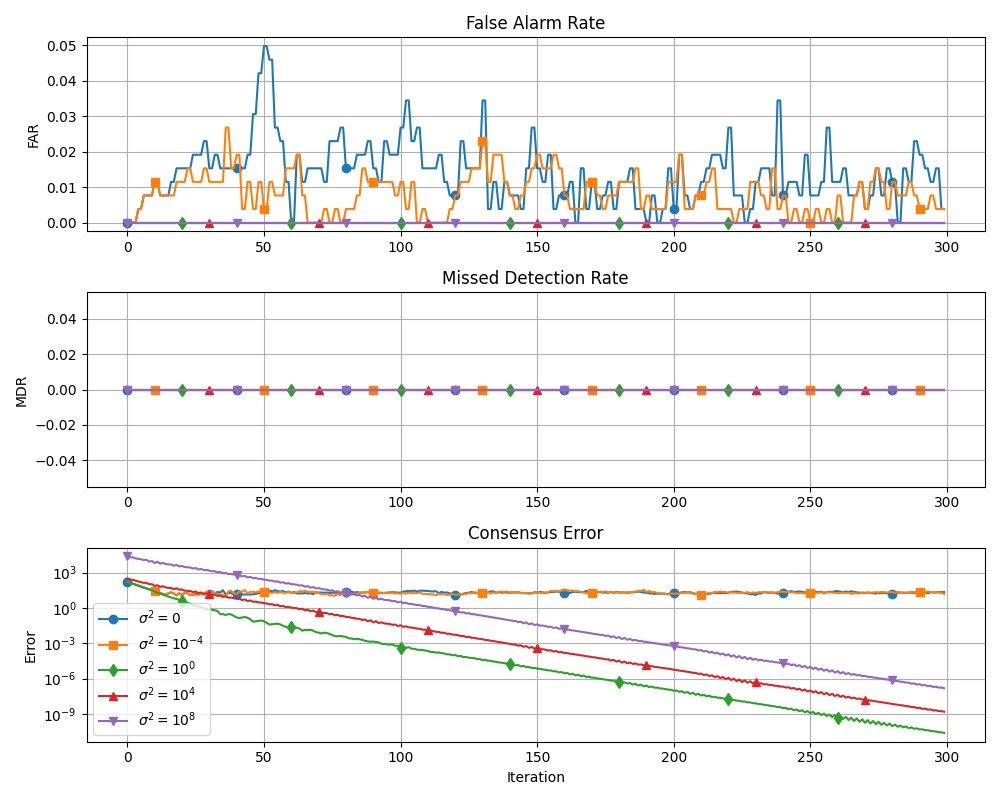

C:\Users\za_re\AppData\Local\Temp\ipykernel_12812\1602430675.py:331: RuntimeWarning: divide by zero encountered in divide
  delta_values = 0.5 * np.log2(1 + sigma_x_sq / sigma_y_sq_values)


[           inf 5.77561380e+00 2.47709816e+00 1.89255812e-01
 2.16080298e-03]


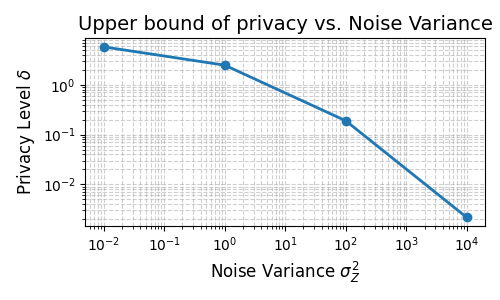

In [13]:
if __name__ == '__main__':
    main()